<a href="https://colab.research.google.com/github/HARISHPG21/ShadowFox/blob/main/task_1_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchsummary numpy matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import torch

# Check device availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Using GPU: CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # For Macbooks with Apple Silicon
    print("✅ Using GPU: Apple MPS")
else:
    device = torch.device("cpu")
    print("⚠️ Using CPU (slowest).")

# Optional: Double check
print(f"Using device: {device}")


✅ Using GPU: CUDA
Using device: cuda


In [ ]:
# Training: Add augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Validation/Test: Only normalize
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:
# Re-create original dataset with `transform=None` so we can apply it manually to subsets
base_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

# Split the raw dataset
train_size = int(0.8 * len(base_train_set))
val_size = len(base_train_set) - train_size
train_dataset_raw, val_dataset_raw = torch.utils.data.random_split(base_train_set, [train_size, val_size])

# Manually apply transforms using transforms property
train_dataset_raw.dataset.transform = train_transform
val_dataset_raw.dataset.transform = test_transform

# Create loaders
train_loader = torch.utils.data.DataLoader(train_dataset_raw, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset_raw, batch_size=4, shuffle=False)

# Test set with test_transform
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False)

In [ ]:
print('Number of images in the training dataset:', len(train_dataset_raw))
print('Number of images in the testing dataset:', len(test_set))

Number of images in the training dataset: 40000
Number of images in the testing dataset: 10000


In [ ]:
print(f"Shape of the images in the training dataset: {train_loader.dataset[0][0].shape}")

Shape of the images in the training dataset: torch.Size([3, 32, 32])


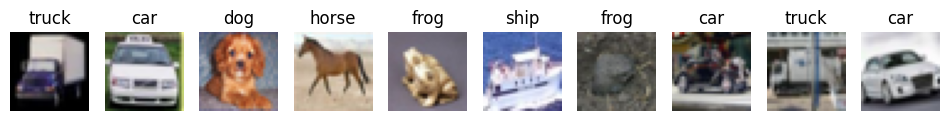

In [ ]:

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    image = train_loader.dataset[i][0].permute(1, 2, 0)
    denormalized_image= image / 2 + 0.5
    axes[i].imshow(denormalized_image)
    axes[i].set_title(classes[train_loader.dataset[i][1]])
    axes[i].axis('off')
plt.show()

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:

class ConvNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),      # (3,32,32) → (64,32,32)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                              # → (64,16,16)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),    # → (128,16,16)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                              # → (128,8,8)

            nn.Conv2d(128, 256, kernel_size=3, padding=1),   # → (256,8,8)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                              # → (256,4,4)

            nn.Dropout(0.3)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))          # → (256,1,1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x



net = ConvNeuralNet()
net.to(device)

ConvNeuralNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.3, inplace=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=

In [ ]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 4]               0
          Dropout-13            [-1, 256, 4, 4]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:

loss_function = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}/{epochs}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1/10,  2000] loss: 1.982
[1/10,  4000] loss: 1.834
[1/10,  6000] loss: 1.735
[1/10,  8000] loss: 1.643
[1/10, 10000] loss: 1.583
[2/10,  2000] loss: 1.515
[2/10,  4000] loss: 1.511
[2/10,  6000] loss: 1.441
[2/10,  8000] loss: 1.404
[2/10, 10000] loss: 1.390
[3/10,  2000] loss: 1.335
[3/10,  4000] loss: 1.316
[3/10,  6000] loss: 1.291
[3/10,  8000] loss: 1.263
[3/10, 10000] loss: 1.240
[4/10,  2000] loss: 1.190
[4/10,  4000] loss: 1.167
[4/10,  6000] loss: 1.181
[4/10,  8000] loss: 1.184
[4/10, 10000] loss: 1.127
[5/10,  2000] loss: 1.074
[5/10,  4000] loss: 1.077
[5/10,  6000] loss: 1.071
[5/10,  8000] loss: 1.054
[5/10, 10000] loss: 1.033
[6/10,  2000] loss: 0.992
[6/10,  4000] loss: 0.988
[6/10,  6000] loss: 0.986
[6/10,  8000] loss: 0.968
[6/10, 10000] loss: 0.985
[7/10,  2000] loss: 0.892
[7/10,  4000] loss: 0.929
[7/10,  6000] loss: 0.907
[7/10,  8000] loss: 0.916
[7/10, 10000] loss: 0.917
[8/10,  2000] loss: 0.850
[8/10,  4000] loss: 0.862
[8/10,  6000] loss: 0.838
[8/10,  8000

In [ ]:
def view_classification(image, probabilities):
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)

    image = image.permute(1, 2, 0)
    denormalized_image= image / 2 + 0.5
    ax1.imshow(denormalized_image)
    ax1.axis('off')
    ax2.barh(np.arange(10), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [ ]:

images, _ = next(iter(test_loader))

image = images[2]
batched_image = image.unsqueeze(0).to(device)
with torch.no_grad():
    log_probabilities = net(batched_image)

probabilities = torch.exp(log_probabilities).squeeze().cpu()
view_classification(image, probabilities)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
y_true = []
y_pred = []

net.eval()  # Set to eval mode

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


In [ ]:
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))


In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(' Confusion Matrix')
plt.show()


In [ ]:
from torch.utils.data import random_split

# Define split sizes
train_size = int(0.8 * len(train_set))   # 80% for training
val_size = len(train_set) - train_size   # 20% for validation

# Create splits
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)


In [ ]:
# After training loop per epoch
val_loss = 0.0
net.eval()  # evaluation mode disables dropout, etc.
with torch.no_grad():
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = net(val_inputs)
        val_loss += loss_function(val_outputs, val_labels).item()

avg_val_loss = val_loss / len(val_loader)
print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")
net.train()  # switch back to training mode


In [ ]:
# Save model state dict
torch.save(net.state_dict(), 'cnn_cifar10.pth')
print("🧠 Model saved as 'cnn_cifar10.pth'")


In [ ]:
# Load model
loaded_model = ConvNeuralNet()
loaded_model.load_state_dict(torch.load('cnn_cifar10.pth', map_location=device))
loaded_model.to(device)
loaded_model.eval()


In [ ]:
from PIL import Image

def predict_image(image_path, model, transform, class_names):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        probs = torch.exp(output)
        top_p, top_class = probs.topk(1, dim=1)

    predicted_class = class_names[top_class.item()]
    confidence = top_p.item()
    return predicted_class, confidence
